In [118]:
import pandas as pd
import collections
from collections import Counter, defaultdict
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tensorflow.keras.models import load_model

# Loading Data

In [5]:
(train,validation,test)= tfds.load('celeb_a', split=['train','validation','test'], as_supervised=False)


loaded


In [16]:
IMG_SIZE=64
def preprocess(sample):
    image = sample['image']
    image = tf.image.resize(image,[IMG_SIZE, IMG_SIZE])
    #Normalization
    image = image/255.0
    # Finetune atrribute
    # Convert directly to int32
    label = tf.cast(sample['attributes']['Smiling'], tf.int32)

    label = tf.where(label == -1, 0, label)
    return image,label

In [58]:
#create a preprocess function for gender subgroup analysis 
def preprocess_fairness(sample):
    image = tf.image.resize(sample['image'], [IMG_SIZE, IMG_SIZE])
    image = image / 255.0

    smiling = tf.cast(sample['attributes']['Smiling'], tf.int32)
    smiling = tf.where(smiling == -1, 0, smiling)

    gender = tf.cast(sample['attributes']['Male'], tf.int32)
    gender = tf.where(gender == -1, 0, gender)

    return image, smiling, gender

In [14]:
BATCH_SIZE=32
BUFFER_SIZE = 1000

In [60]:
# Batch the dataset 

train_batches = (
    train
    .shuffle(BUFFER_SIZE)
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

validation_batches = (
    validation
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

fairness_batches = (
    test
    .map(preprocess_fairness)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset Exploratory Analysis & Imbalance

In [19]:
# Create function to count data
def attribute_counts(raw_train,raw_validation,raw_test):
    counter = Counter()
    for i in raw_train:
        male = int(i['attributes']['Male']  )    # Male label
        smiling = int(i['attributes']['Smiling'])# Smiling label
        counter[(male,smiling)]+=1
    for i in raw_test:
        male = int(i['attributes']['Male']  )    # Male label
        smiling = int(i['attributes']['Smiling'])# Smiling label
        counter[(male,smiling)]+=1
    for i in raw_validation:
        male = int(i['attributes']['Male']  )    # Male label
        smiling = int(i['attributes']['Smiling'])# Smiling label
        counter[(male,smiling)]+=1
    return counter
    
counts=attribute_counts(train,validation,test)
print('The number of females smiling: ',counts[(0,1)] )
print('The number of females not smiling:',counts[(0,0)])
print('The total number of females: ', counts[(0,1)]+counts[(0,0)])
print('The number of males smiling:' ,counts[(1,1)])
print('The number of males not smiling:', counts[(1,0)])
print('The total number of males:', counts[(1,1)]+counts[(1,0)])

2025-12-29 20:21:24.486625: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-29 20:21:29.062059: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The number of females smiling:  63871
The number of females not smiling: 54294
The total number of females:  118165
The number of males smiling: 33798
The number of males not smiling: 50636
The total number of males: 84434


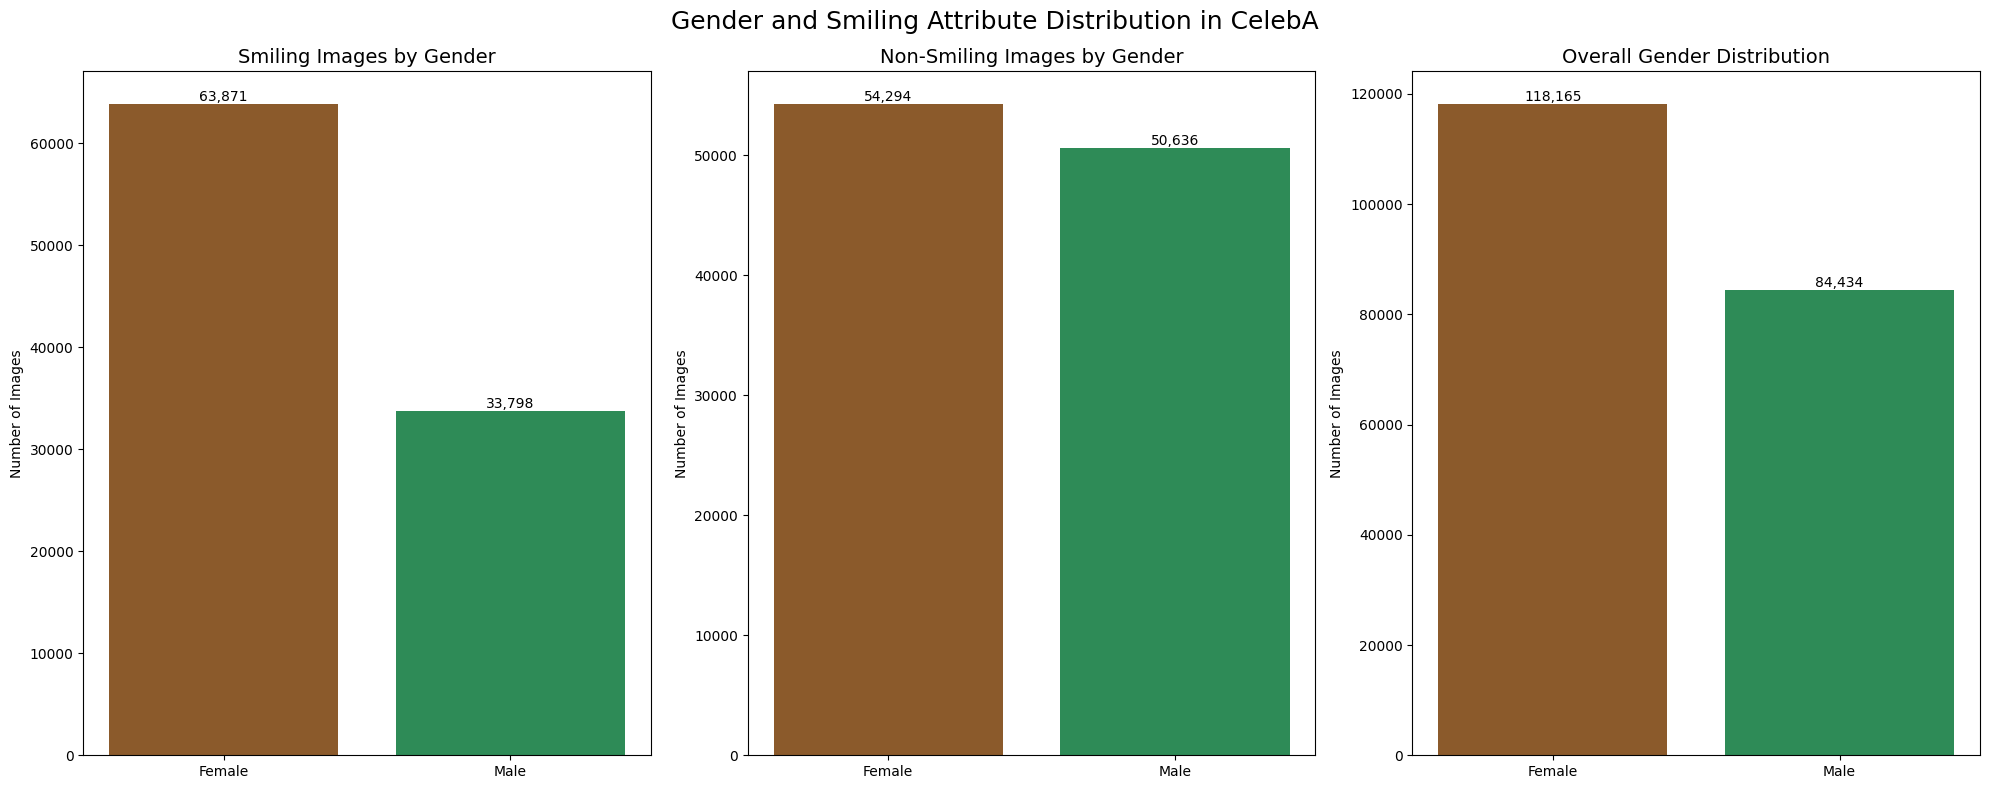

In [20]:
# Visualize attribute counts
def plot_attributes(counts):
    # Extract counts
    female_smiling = counts[(0,1)]
    female_notsmiling = counts[(0,0)]
    female_total = female_smiling + female_notsmiling

    male_smiling = counts[(1,1)]
    male_notsmiling = counts[(1,0)]
    male_total = male_smiling + male_notsmiling

    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

    categories = ["Female", "Male"]
    colors = ["#8B5A2B", "#2E8B57"]  # Brown (Female), Green (Male)

    ax1.set_title("Smiling Images by Gender", fontsize=14)
    values1 = [female_smiling, male_smiling]
    bars1 = ax1.bar(categories, values1, color=colors)
    ax1.set_ylabel("Number of Images")

    # Add value labels
    for bar in bars1:
        ax1.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height(),
                 f"{bar.get_height():,}",
                 ha="center", va="bottom")

    # --- Plot 2: Not Smiling ---
    ax2.set_title("Non-Smiling Images by Gender", fontsize=14)
    values2 = [female_notsmiling, male_notsmiling]
    bars2 = ax2.bar(categories, values2, color=colors)
    ax2.set_ylabel("Number of Images")

    for bar in bars2:
        ax2.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height(),
                 f"{bar.get_height():,}",
                 ha="center", va="bottom")

    ax3.set_title("Overall Gender Distribution", fontsize=14)
    values3 = [female_total, male_total]
    bars3 = ax3.bar(categories, values3, color=colors)
    ax3.set_ylabel("Number of Images")

    for bar in bars3:
        ax3.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height(),
                 f"{bar.get_height():,}",
                 ha="center", va="bottom")

    # Overall title
    fig.suptitle("Gender and Smiling Attribute Distribution in CelebA",
                 fontsize=18)

    fig.tight_layout()
plot_attributes(counts)

# Dataset Interpretation

Among smiling images, female subjects constitute a 65% proportion of the dataset, while male smiling subjects account for 35%, This imbalance suggests that the classifier may learn smiling-related features more effectively for female faces than for male faces.

A similar imbalance is observed in non-smiling images, indicating that the gender skew is consistent across facial expression categories rather than isolated to smiling alone.

Overall, female images represent a higher proportion of the dataset than male images. As a result, accuracy may overestimate model performance if subgroup-level disparities are not examined

In [21]:
#Data Visualization
def show_images(dataset):
    plt.figure(figsize=(10, 10))

    for i, (image, label) in enumerate(dataset.take(25)):
        ax = plt.subplot(5, 5, i + 1)   
        plt.imshow(image)
        graph_label= tf.where(label==0,False,True)
        plt.title(f"Smiling: {graph_label.numpy()}")
        plt.axis("off")

    plt.show()

I used a three-block convolutional architecture, which provides sufficient capacity to learn expression-level features while minimizing overfitting and maintaining interpretability for bias analysis.





In [22]:
def build_cnn_model(
    input_shape=(64, 64, 3), # width heigh channels
    num_classes=1,
    learning_rate=1e-3
):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

    

# Model Training

In [23]:
# creating training model parameters
#Defining model
model = build_cnn_model()
# creatingcallbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience =3, mode='min', restore_best_weights=True)
# defining max_epochs
epoch= 30

In [25]:
# Model Training
#creating training function
def train_model(model, train_data, val_data, max_epochs, callbacks):
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=max_epochs,
        callbacks=callbacks
    
    )
    return model, history
          


In [26]:
# training model
training_model, training_history = train_model(
    model=model,
    train_data=train_batches,
    val_data=validation_batches,
    max_epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 414s 81ms/step - accuracy: 0.8884 - loss: 0.2626 - val_accuracy: 0.9030 - val_loss: 0.2296
Epoch 2/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 428s 84ms/step - accuracy: 0.9055 - loss: 0.2233 - val_accuracy: 0.9101 - val_loss: 0.2103
Epoch 3/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 420s 83ms/step - accuracy: 0.9123 - loss: 0.2075 - val_accuracy: 0.9178 - val_loss: 0.1982
Epoch 4/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 410s 81ms/step - accuracy: 0.9160 - loss: 0.1985 - val_accuracy: 0.9196 - val_loss: 0.1931
Epoch 5/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 408s 80ms/step - accuracy: 0.9184 - loss: 0.1930 - val_accuracy: 0.9186 - val_loss: 0.1932
Epoch 6/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 619s 122ms/step - accuracy: 0.9211 - loss: 0.1869 - val_accuracy: 0.9208 - val_loss: 0.1894
Epoch 7/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 1633s 321ms/step - accuracy: 0.9231 - loss: 0.1822 - val_accuracy: 0.9106 - val_loss: 0.2125
Epoch 8/30
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 177s 35ms/step - accurac

# Model Evaluation

In [102]:
#Overall accuracy
loss, overall_accuracy = model.evaluate(fairness_batches, verbose=0)
print("Overall accuracy:", overall_accuracy)

Overall accuracy: 0.9184951186180115


In [103]:
# Subgroup Model Evaluation
def subgroup_accuracy(model, dataset):
    correct = defaultdict(int)
    total = defaultdict(int)

    for images, smiling,gender in dataset:
        
        smiling = smiling.numpy().flatten()
        gender = gender.numpy().flatten()

        preds = model.predict(images, verbose=0)
        preds = (preds > 0.5).astype(int).flatten()

        for i in range(len(smiling)):
            s = smiling[i]
            g = gender[i]
            p = preds[i]

            if g == 0 and s == 1:
                subgroup = "female_smiling"
            elif g == 0 and s == 0:
                subgroup = "female_not_smiling"
            elif g == 1 and s == 1:
                subgroup = "male_smiling"
            else:
                subgroup = "male_not_smiling"

            total[subgroup] += 1
            correct[subgroup] += int(p == s)

    return {k: correct[k] / total[k]for k in total}

subgroup_accuracy(model,fairness_batches)


{'female_smiling': 0.9202089075874075,
 'male_not_smiling': 0.9391906513741615,
 'female_not_smiling': 0.9329473290997385,
 'male_smiling': 0.8587588881706528}

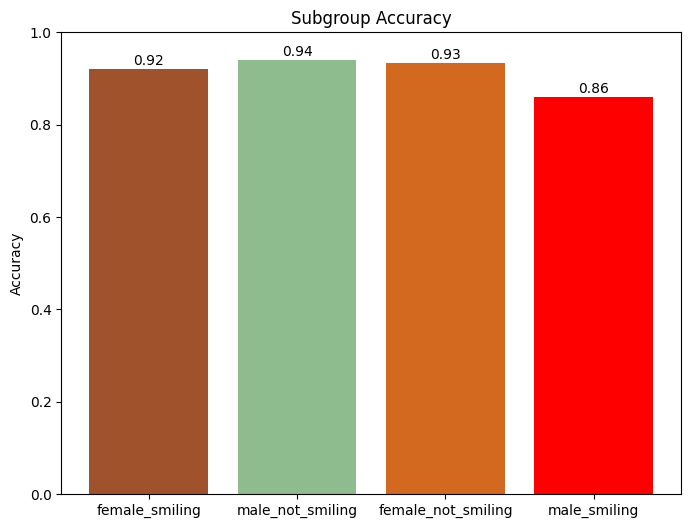

In [115]:
def plot_subgroup_accuracy(subgroup_acc):
    categories = list(subgroup_acc.keys())
    values = list(subgroup_acc.values())

    colors = ["#a0522d", "#8fbc8f", "#d2691e", "#FF0000"]  # Brown & Green shades
    plt.figure(figsize=(8,6))
    plt.bar(categories, values, color=colors)
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Subgroup Accuracy")
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
    
    plt.show()
subgroup_acc = subgroup_accuracy(model, fairness_batches)
plot_subgroup_accuracy(subgroup_acc)

# Subgroup Accuracy Analysis

The model’s performance varies across different subgroups:
	•	Female Smiling: 0.92
	•	The model correctly identifies smiling females 92% of the time.
	•	Female Not Smiling: 0.93
	•	Slightly better performance in recognizing females who are not smiling.
	•	Male Smiling: 0.86
	•	Accuracy drops noticeably for males who are smiling, indicating the model struggles more with this subgroup.
	•	Male Not Smiling: 0.94
	•	The model performs best in identifying males who are not smiling.

Interpretation:
	•	Overall, the model performs well across all subgroups, but there is a clear disparity: male smiling images are the most challenging for the model.
	•	This could be due to an imbalance in the training dataset or subtle differences in how smiles manifest in male faces compared to female faces.
	•	The slightly higher accuracy for non-smiling subgroups suggests the model finds it easier to detect the absence of a smile than a smile, especially for males.


# Error Analysis

In [99]:
# Error analysis
def subgroup_confusionmatrix_heatmap(model, dataset):
    # Initialize dictionary for each subgroup
    subgroups = {
        "female": {"TP":0, "TN":0, "FP":0, "FN":0},
        "male": {"TP":0, "TN":0, "FP":0, "FN":0},
    }

    for images, smiling, gender in dataset:
        smiling = smiling.numpy().flatten()
        gender = gender.numpy().flatten()
        preds = model.predict(images, verbose=0)
        preds = (preds > 0.5).astype(int).flatten()

        for i in range(len(smiling)):
            s = smiling[i]
            g = gender[i]
            p = preds[i]

            sg = "female" if g==0 else "male"

            if s == 1 and p == 1:
                subgroups[sg]["TP"] += 1
            elif s == 1 and p == 0:
                subgroups[sg]["FN"] += 1
            elif s == 0 and p == 1:
                subgroups[sg]["FP"] += 1
            elif s == 0 and p == 0:
                subgroups[sg]["TN"] += 1

    # Convert to DataFrame for heatmap
    return subgroups

# Evaluation Visaulization

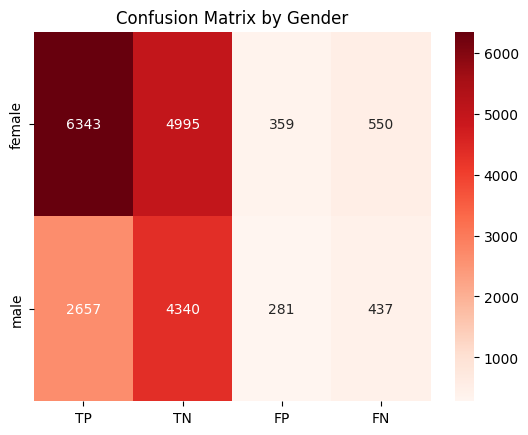

          TP    TN   FP   FN
female  6343  4995  359  550
male    2657  4340  281  437


In [104]:
# confusion matrix 
cm =subgroup_confusionmatrix_heatmap(model, fairness_batches)
data = pd.DataFrame(cm).T
sns.heatmap(data, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix by Gender")
plt.show()
print(data)

# Saving Model

In [119]:
# Save the trained model
model.save("smiling_cnn_model.keras")
# For .keras
model = load_model("smiling_cnn_model.keras", compile=True)

# Optionally, save the subgroup accuracy results
subgroup_acc = subgroup_accuracy(model, fairness_batches)
with open("subgroup_accuracy.json", "w") as f:
    json.dump(subgroup_acc, f)

# Save overall accuracy
loss, overall_acc = model.evaluate(fairness_batches, verbose=0)
with open("overall_accuracy.txt", "w") as f:
    f.write(f"Overall Accuracy: {overall_acc}")